In [1]:
'''This script demonstrates how to entangle digit with fashion mnist
'''
import vae_tools.tfkeras
import sys, os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from IPython.display import SVG

from keras.utils import model_to_dot
from keras.layers import Input, Dense, Lambda, Flatten, Reshape, Layer, BatchNormalization
from keras.layers import concatenate as concat
from keras.layers import Conv2D, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.utils import to_categorical
import keras
from vae_tools import plot_confusion_matrix, plot_model, layers, nb_tools, viz, loader, build_model, sanity, sampling, custom_variational_layer, metrics, build_model

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
sanity.check()

sampling.set_seed()

# input image dimensions
img_rows, img_cols, img_chns = 28, 28, 1
if K.image_data_format() == 'channels_first':
    original_img_size = (img_chns, img_rows, img_cols)
else:
    original_img_size = (img_rows, img_cols, img_chns)
# number of convolutional filters to use
filters = 64
# convolution kernel size
num_conv = 3
# batch size
batch_size = 1024
# latent dim
latent_dim = 2

# Hyperparameters
# Beta
beta = 4.0
# use fashion mnist or not (digit)
use_fashion = 0
# epochs
epochs = 300
# deep
deep = True

try:
    _beta = np.float(os.environ['BETA'])
    _label = np.int(os.environ['LABEL'])
    _epochs = np.int(os.environ['EPOCHS'])
    _use_fashion = np.int(os.environ['USE_FASHION'])
    _latent_dim = np.int(os.environ['DIM_LATENT'])
    latent_dim = _latent_dim
    beta = _beta
    label = _label
    epochs = _epochs
    use_fashion = _use_fashion
    print("WARNING: Set parameters from environment")
except:
    pass

deep_str = ""
if deep == True:
    deep_str = "_deep"
prefix = "eMNSIT_CVAE_fashion-" + str(use_fashion) + "_latent_dim-" + str(latent_dim) + deep_str + "_beta-" + str(beta) + "_epochs-" + str(epochs)


python version:  3.5.2
keras version: 2.2.4-tf
tensorflow version: 2.0.0
matplotlib uses:  module://ipykernel.pylab.backend_inline
Available GPUs True


In [2]:
class Cvae2dConv(sampling.Sampling, build_model.GenericVae):
    ''' Vanilla CVAE with 2d convolutions
    '''
    def __init__(self):
        pass
    
    def configure(self, img_rows, img_cols, img_chns, batch_size, label_dim, filters, num_conv, intermediate_dim, latent_dim, beta, deep = False):
        self.latent_dim = latent_dim
        self.intermediate_dim = intermediate_dim
        self.intermediate_dim_2 = np.int(intermediate_dim / 2)
        self.deep = deep
        self.label_dim = label_dim

        # build the net
        if K.image_data_format() == 'channels_first':
            original_img_size = (img_chns, img_rows, img_cols)
        else:
            original_img_size = (img_rows, img_cols, img_chns)
        self.original_dim = np.int(np.prod(original_img_size))

        img_rows_2 = np.int(img_rows / 2)
        img_cols_2 = np.int(img_cols / 2)

        self.x = Input(shape=original_img_size)
        self.label = Input(shape=(label_dim,))
        self.conv_1 = Conv2D(img_chns, kernel_size=(2, 2), padding='same', activation='relu')(self.x)
        self.conv_2 = Conv2D(filters, kernel_size=(2, 2), padding='same', activation='relu', strides=(2, 2))(self.conv_1)
        self.conv_3 = Conv2D(filters, kernel_size=num_conv, padding='same', activation='relu', strides=1)(self.conv_2)
        self.conv_4 = Conv2D(filters, kernel_size=num_conv, padding='same', activation='relu', strides=1)(self.conv_3)
        self.flat = Flatten()(self.conv_4)
        self.flat_concat = concat([self.flat, self.label])
        self.hidden = Dense(intermediate_dim, activation='relu')(self.flat_concat)
        if deep == True:
            self.hidden_2 = Dense(self.intermediate_dim_2, activation='relu')(self.hidden)
        else:
            self.hidden_2 = self.hidden
        self.z_mean = Dense(latent_dim)(self.hidden_2)
        self.z_log_var = Dense(latent_dim)(self.hidden_2)

        self.z = Lambda(self.randn, output_shape=(latent_dim,))([self.z_mean, self.z_log_var])
        self.z_bn = BatchNormalization()(self.z)

        # we instantiate these layers separately so as to reuse them later
        self.decoder_hid_2 = Dense(self.intermediate_dim_2, activation='relu')
        self.decoder_hid = Dense(intermediate_dim, activation='relu')
        self.decoder_upsample = Dense(filters * img_rows_2 * img_cols_2, activation='relu')

        if K.image_data_format() == 'channels_first':
            output_shape = (batch_size, filters, img_rows_2, img_cols_2)
        else:
            output_shape = (batch_size, img_rows_2, img_cols_2, filters)

        self.decoder_reshape = Reshape(output_shape[1:])
        self.decoder_deconv_1 = Conv2DTranspose(filters, kernel_size=num_conv, padding='same', strides=1, activation='relu')
        self.decoder_deconv_2 = Conv2DTranspose(filters, kernel_size=num_conv, padding='same', strides=1, activation='relu')
        if K.image_data_format() == 'channels_first':
            output_shape = (batch_size, filters, np.int(img_rows + 1), np.int(img_cols + 1))
        else:
            output_shape = (batch_size, np.int(img_rows + 1), np.int(img_cols + 1), filters)
        self.decoder_deconv_3_upsamp = Conv2DTranspose(filters, kernel_size=(3, 3), strides=(2, 2), padding='valid', activation='relu')
        self.decoder_mean_squash = Conv2D(img_chns, kernel_size=2, padding='valid', activation='sigmoid')

        self.z_bn_label_concat = concat([self.z_bn, self.label])
        if deep == True:
            self.hid_decoded_2 = self.decoder_hid_2(self.z_bn_label_concat)
            self.hid_decoded = self.decoder_hid(self.hid_decoded_2)
        else:
            self.hid_decoded = self.decoder_hid(self.z_bn_label_concat)
        self.up_decoded = self.decoder_upsample(self.hid_decoded)
        self.reshape_decoded = self.decoder_reshape(self.up_decoded)
        self.deconv_1_decoded = self.decoder_deconv_1(self.reshape_decoded)
        self.deconv_2_decoded = self.decoder_deconv_2(self.deconv_1_decoded)
        self.x_decoded_relu = self.decoder_deconv_3_upsamp(self.deconv_2_decoded)
        self.x_decoded_mean_squash = self.decoder_mean_squash(self.x_decoded_relu)

        self.y = custom_variational_layer.VaeLoss(self.original_dim, beta = beta, reconstruction_mse = False)([self.x, self.x_decoded_mean_squash, self.z_mean, self.z_log_var])

    def get_model(self, get_new_model = False):
        if 'model' not in dir(self) or get_new_model:
            self.model = Model([self.x, self.label], self.y)
        return self.model

    def get_encoder_mean(self):
        return Model([self.x, self.label], self.z_mean)

    def get_encoder_logvar(self):
        return Model([self.x, self.label], self.z_log_var)
    
    def get_decoder(self):
        self.decoder_input = Input(shape=(self.latent_dim,))
        self.label_input = Input(shape=(self.label_dim,))
        self.decoder_label_concat_input = concat([self.decoder_input, self.label_input])
        if self.deep == True:
            self._hid_decoded_2 = self.decoder_hid_2(self.decoder_label_concat_input)
            self._hid_decoded = self.decoder_hid(self._hid_decoded_2)
        else:
            self._hid_decoded = self.decoder_hid(self.decoder_label_concat_input)
        self._up_decoded = self.decoder_upsample(self._hid_decoded)
        self._reshape_decoded = self.decoder_reshape(self._up_decoded)
        self._deconv_1_decoded = self.decoder_deconv_1(self._reshape_decoded)
        self._deconv_2_decoded = self.decoder_deconv_2(self._deconv_1_decoded)
        self._x_decoded_relu = self.decoder_deconv_3_upsamp(self._deconv_2_decoded)
        self._x_decoded_mean_squash = self.decoder_mean_squash(self._x_decoded_relu)
        return Model([self.decoder_input, self.label_input], self._x_decoded_mean_squash)

model_obj = Cvae2dConv()
model_obj.configure(img_rows = img_rows, img_cols = img_cols, img_chns = img_chns, label_dim = 10,
                    batch_size = batch_size, filters = 64, num_conv = 3,
                    intermediate_dim = 128,
                    latent_dim = latent_dim,
                    beta = beta,
                    deep = False)

vae = model_obj.get_model()
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()
#SVG(model_to_dot(vae).create(prog='dot', format='svg'))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 1)    5           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 64)   320         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_1[0][0]                   
______________________________________________________________________________________________

In [3]:
# train the VAE on MNIST digits
if use_fashion==1:
    x_train, y_train, x_test, y_test = loader.mnist(new_shape = original_img_size, kind='fashion', get_single_label = None)
else:
    x_train, y_train, x_test, y_test = loader.mnist(new_shape = original_img_size, kind='digit', get_single_label = None)
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

In [4]:
#epochs = 200
vae.fit([x_train, y_train_cat], shuffle=True, epochs=epochs, batch_size=batch_size, validation_data=([x_test, y_test_cat], None))
#epochs = 600
#prefix = "eMNSIT_CVAE_fashion-" + str(use_fashion) + "_latent_dim-" + str(latent_dim) + deep_str + "_beta-" + str(beta) + "_epochs-" + str(epochs)
model_obj.store_model(prefix + "_model-decoder", model_obj.get_decoder(), overwrite = True)
model_obj.store_model(prefix + "_model-encoder-logvar", model_obj.get_encoder_logvar(), overwrite = True)
model_obj.store_model(prefix + "_model-encoder-mean", model_obj.get_encoder_mean(), overwrite = True)

Train on 60000 samples, validate on 10000 samples
Epoch 1/300
60000/60000 [==============================] - 7s 116us/sample - loss: 216.4030 - val_loss: 172.3416
Epoch 2/300
60000/60000 [==============================] - 3s 57us/sample - loss: 163.1725 - val_loss: 159.0369
Epoch 3/300
60000/60000 [==============================] - 3s 58us/sample - loss: 151.7586 - val_loss: 149.9284
Epoch 4/300
60000/60000 [==============================] - 3s 58us/sample - loss: 148.2483 - val_loss: 148.0080
Epoch 5/300
60000/60000 [==============================] - 3s 58us/sample - loss: 145.8853 - val_loss: 147.5272
Epoch 6/300
60000/60000 [==============================] - 3s 58us/sample - loss: 144.0341 - val_loss: 143.2731
Epoch 7/300
60000/60000 [==============================] - 3s 57us/sample - loss: 142.6870 - val_loss: 142.5770
Epoch 8/300
60000/60000 [==============================] - 3s 58us/sample - loss: 141.2870 - val_loss: 142.0463
Epoch 9/300
60000/60000 [============================

save to:  eMNSIT_CVAE_fashion-0_latent_dim-2_deep_beta-4.0_epochs-300_z.png


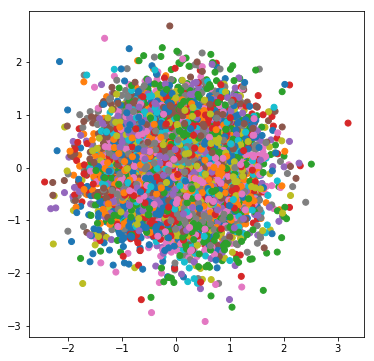

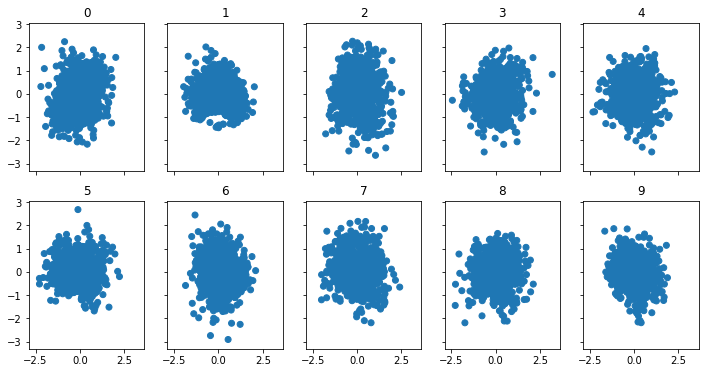

save to:  eMNSIT_CVAE_fashion-0_latent_dim-2_deep_beta-4.0_epochs-300_z_unique.png


<Figure size 432x288 with 0 Axes>

save to:  eMNSIT_CVAE_fashion-0_latent_dim-2_deep_beta-4.0_epochs-300_x.png


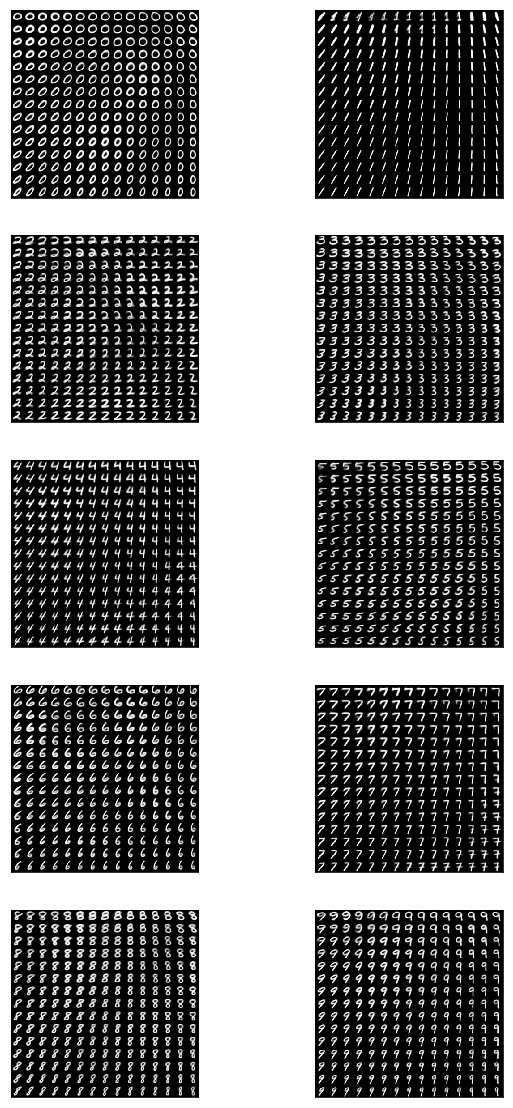

In [5]:
# build a model to project inputs on the latent space
encoder_mean = model_obj.get_encoder_mean()
encoder_log_var = model_obj.get_encoder_logvar()
x_encoded = encoder_mean.predict([x_test, y_test_cat], batch_size=batch_size)
x_encoded_std = np.exp(encoder_log_var.predict([x_test, y_test_cat], batch_size=batch_size) / 2.0)

if latent_dim == 2:
    # display a 2D plot of the digit classes in the latent space
    plt.figure(figsize=(6, 6))
    plt.scatter(x_encoded[:, 0], x_encoded[:, 1], c=y_test, cmap='tab10')
    save_str = prefix + "_z" + ".png"
    plt.savefig(save_str, dpi=300)
    print("save to: ", save_str)
    plt.show(block=False)
    
    # display a 2D plot of the digit classes in the latent space
    f, ax = plt.subplots(2,5,figsize=(12, 6), sharex=True, sharey=True)
    for idx in range(5):
        ax[0,idx].scatter(x_encoded[y_test==idx, 0], x_encoded[y_test==idx, 1], c=idx*np.ones((np.sum(y_test==idx),)), cmap='tab10')
        ax[0,idx].set_title(idx)
        ax[1,idx].scatter(x_encoded[y_test==idx+5, 0], x_encoded[y_test==idx+5, 1], c=idx*np.ones((np.sum(y_test==idx+5),)), cmap='tab10')
        ax[1,idx].set_title(idx+5)
    plt.show(block=False)
    save_str = prefix + "_z_unique" + ".png"
    plt.savefig(save_str, dpi=300)
    print("save to: ", save_str)
    plt.show(block=False)

    # build a digit generator that can sample from the learned distribution
    generator = model_obj.get_decoder()

    fig, ax = plt.subplots(ncols=2, nrows=5, figsize=(10,20))
    _ax = ax.flatten()
    for label in np.arange(0,10):
        # display a 2D manifold of the digits
        n = 15  # figure with 15x15 digits
        digit_size = 28
        figure = np.zeros((digit_size * n, digit_size * n))
        # linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
        # to produce values of the latent variables z, since the prior of the latent space is Gaussian
        grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
        grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
        for i, yi in enumerate(grid_x):
            for j, xi in enumerate(grid_y):
                z_sample = np.array([[xi, yi]])
                y_sample_cat = np.zeros((1,10))
                y_sample_cat[0,label] = 1
                x_decoded = generator.predict([z_sample, y_sample_cat])
                digit = x_decoded[0].reshape(digit_size, digit_size)
                figure[i * digit_size: (i + 1) * digit_size,
                       j * digit_size: (j + 1) * digit_size] = digit

        # _ax[label].figure(figsize=(10, 10))
        _ax[label].imshow(figure, cmap='Greys_r')
        _ax[label].set_xticks([])
        _ax[label].set_yticks([])
    save_str = prefix + "_x" + ".png"
    plt.savefig(save_str, dpi=300)
    print("save to: ", save_str)
    plt.show(block=False)


# get statistics per dimension
if False:
    fig, ax = plt.subplots(ncols=2, figsize=(20,10))
    x_encoded_std_mean = np.mean(x_encoded_std, axis=0)
    x_std_encoded = np.std(x_encoded, axis=0)
    ax[0].bar(np.arange(1,latent_dim + 1), x_encoded_std_mean, width=0.8)
    ax[0].set_title("Mean sampled standard deviation per dimension")
    ax[1].bar(np.arange(1,latent_dim + 1), x_std_encoded, width=0.8)
    ax[1].set_title("Standard deviation of sampled means per dimension")
    asp = np.diff(ax[0].get_xlim())[0] / np.diff(ax[0].get_ylim())[0]
    ax[0].set_aspect(asp)
    asp = np.diff(ax[1].get_xlim())[0] / np.diff(ax[1].get_ylim())[0]
    ax[1].set_aspect(asp)
    save_str = prefix + "_z_statistics" + ".png"
    plt.savefig(save_str, dpi=300)
    print("save to: ", save_str)
    plt.show(block=False)

In [6]:
from scipy import stats
#stats.normaltest
def my_test(idx = 0, dim = 0):
    k2, p = stats.normaltest(x_encoded[y_test==idx, dim])
    alpha = 1e-3
    print("p = {:g}".format(p))

    if p < alpha:  # null hypothesis: x comes from a normal distribution
        print("non-normal " + str(idx) + ": The null hypothesis can be rejected")
    else:
        print("normal " + str(idx) + ": The null hypothesis cannot be rejected")
for idx in range(9):
    my_test(idx, 1)

p = 0.084641
normal 0: The null hypothesis cannot be rejected
p = 1.09085e-06
non-normal 1: The null hypothesis can be rejected
p = 0.129804
normal 2: The null hypothesis cannot be rejected
p = 0.00741331
normal 3: The null hypothesis cannot be rejected
p = 0.403593
normal 4: The null hypothesis cannot be rejected
p = 0.000259547
non-normal 5: The null hypothesis can be rejected
p = 0.0138992
normal 6: The null hypothesis cannot be rejected
p = 6.0652e-05
non-normal 7: The null hypothesis can be rejected
p = 1.30033e-05
non-normal 8: The null hypothesis can be rejected
